# Improved GNN Movie Recommender v2

**Key improvements over previous versions:**

1. ✅ **Proper loss function** - Only train on observed ratings
2. ✅ **Bias terms** - User bias + Movie bias + **Global mean**
3. ✅ **Rating normalization** - Subtract mean before training, add back after
4. ✅ **Edge weights** - Use actual rating values
5. ✅ **Regularization** - λ(||X||² + ||W||²)

**Prediction formula (same as your TensorFlow code):**
```
prediction = X @ W.T + user_bias + movie_bias + global_mean
```

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torch_geometric.nn import GCNConv, SAGEConv, LGConv
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

print("Libraries loaded!")

Libraries loaded!


---
## Part 1: Load and Prepare Data

In [34]:
# Load MovieLens data
df_ratings = pd.read_csv('/Users/pelinbalci/PycharmProjects/MovieRecommendation/data/ml-latest-small/ratings.csv')
df_movies = pd.read_csv('/Users/pelinbalci/PycharmProjects/MovieRecommendation/data/ml-latest-small/movies.csv')

print(f"Total ratings: {len(df_ratings)}")
print(f"Users: {df_ratings['userId'].nunique()}")
print(f"Movies: {df_ratings['movieId'].nunique()}")
print(f"Rating range: {df_ratings['rating'].min()} - {df_ratings['rating'].max()}")
print(f"Average rating: {df_ratings['rating'].mean():.4f}")

Total ratings: 100836
Users: 610
Movies: 9724
Rating range: 0.5 - 5.0
Average rating: 3.5016


In [35]:
# Create ID mappings
unique_users = sorted(df_ratings['userId'].unique())
unique_movies = sorted(df_ratings['movieId'].unique())

user_to_idx = {user: idx for idx, user in enumerate(unique_users)}
movie_to_idx = {movie: idx for idx, movie in enumerate(unique_movies)}
idx_to_user = {idx: user for user, idx in user_to_idx.items()}
idx_to_movie = {idx: movie for movie, idx in movie_to_idx.items()}

num_users = len(unique_users)
num_movies = len(unique_movies)
num_nodes = num_users + num_movies

print(f"num_users: {num_users}")
print(f"num_movies: {num_movies}")
print(f"num_nodes: {num_nodes}")

num_users: 610
num_movies: 9724
num_nodes: 10334


In [36]:
# Convert to indices
user_indices = np.array([user_to_idx[u] for u in df_ratings['userId']])
movie_indices = np.array([movie_to_idx[m] for m in df_ratings['movieId']])
ratings = df_ratings['rating'].values.astype(np.float32)

print(f"Data shapes: users {user_indices.shape}, movies {movie_indices.shape}, ratings {ratings.shape}")

Data shapes: users (100836,), movies (100836,), ratings (100836,)


---
## Part 2: Calculate Global Mean and Normalize Ratings


```python
Ymean = (np.sum(Y * R, axis=1) / (np.sum(R, axis=1) + 1e-12)).reshape(-1, 1)
Ynorm = Y - np.multiply(Ymean, R)
```

In [37]:
# Calculate GLOBAL mean (average of all ratings)
global_mean = ratings.mean()
print(f"Global mean rating: {global_mean:.4f}")

# Calculate per-movie mean
movie_rating_sum = np.zeros(num_movies)
movie_rating_count = np.zeros(num_movies)

for m_idx, r in zip(movie_indices, ratings):
    movie_rating_sum[m_idx] += r
    movie_rating_count[m_idx] += 1

# Avoid division by zero - use global mean for movies with no ratings
movie_means = np.where(
    movie_rating_count > 0,
    movie_rating_sum / movie_rating_count,
    global_mean
)

print(f"Movie means range: {movie_means.min():.2f} - {movie_means.max():.2f}")

# Normalize ratings: subtract movie mean (like your TF code)
ratings_normalized = ratings - movie_means[movie_indices]

print(f"Normalized ratings range: {ratings_normalized.min():.2f} to {ratings_normalized.max():.2f}")
print(f"Normalized ratings mean: {ratings_normalized.mean():.6f} (should be ~0)")

Global mean rating: 3.5016
Movie means range: 0.50 - 5.00
Normalized ratings range: -3.77 to 3.07
Normalized ratings mean: 0.000000 (should be ~0)


In [38]:
# Train/Test split
train_idx, test_idx = train_test_split(
    np.arange(len(ratings)), 
    test_size=0.2, 
    random_state=42
)

# Training data
train_users = user_indices[train_idx]
train_movies = movie_indices[train_idx]
train_ratings = ratings[train_idx]
train_ratings_norm = ratings_normalized[train_idx]

# Test data  
test_users = user_indices[test_idx]
test_movies = movie_indices[test_idx]
test_ratings = ratings[test_idx]
test_ratings_norm = ratings_normalized[test_idx]

print(f"Training samples: {len(train_idx)}")
print(f"Test samples: {len(test_idx)}")

Training samples: 80668
Test samples: 20168


---
## Part 3: Build Graph with Edge Weights

In [39]:
# Build edge index
train_users_t = torch.tensor(train_users, dtype=torch.long)
train_movies_t = torch.tensor(train_movies, dtype=torch.long)

# Movie node indices (shifted by num_users)
movie_node_indices = train_movies_t + num_users

# Bidirectional edges
edge_index = torch.stack([
    torch.cat([train_users_t, movie_node_indices]),
    torch.cat([movie_node_indices, train_users_t])
], dim=0)

# Edge weights: rating values normalized to 0-1
train_ratings_for_weights = torch.tensor(train_ratings, dtype=torch.float32)
edge_weights = train_ratings_for_weights / 5.0
edge_weights = torch.cat([edge_weights, edge_weights])  # Bidirectional

print(f"edge_index shape: {edge_index.shape}")
print(f"edge_weights shape: {edge_weights.shape}")
print(f"edge_weights range: {edge_weights.min():.2f} - {edge_weights.max():.2f}")

edge_index shape: torch.Size([2, 161336])
edge_weights shape: torch.Size([161336])
edge_weights range: 0.10 - 1.00


In [40]:
# Convert to tensors
train_users_t = torch.tensor(train_users, dtype=torch.long)
train_movies_t = torch.tensor(train_movies, dtype=torch.long)
train_ratings_t = torch.tensor(train_ratings, dtype=torch.float32)
train_ratings_norm_t = torch.tensor(train_ratings_norm, dtype=torch.float32)

test_users_t = torch.tensor(test_users, dtype=torch.long)
test_movies_t = torch.tensor(test_movies, dtype=torch.long)
test_ratings_t = torch.tensor(test_ratings, dtype=torch.float32)

# Store means as tensors
movie_means_t = torch.tensor(movie_means, dtype=torch.float32)
global_mean_t = torch.tensor(global_mean, dtype=torch.float32)

print(f"Global mean: {global_mean_t.item():.4f}")
print("Data tensors ready!")

Global mean: 3.5016
Data tensors ready!


---
## Part 4: Model Definitions

**Key: All models now include global_mean in prediction!**

```
prediction = dot(user, movie) + user_bias + movie_bias + global_mean
```

This matches your TensorFlow code:
```python
p = np.matmul(X.numpy(), np.transpose(W.numpy())) + b.numpy()
pm = p + Ymean  # restore the mean
```

### Model 1: Improved Matrix Factorization

In [64]:
class ImprovedMF(nn.Module):
    """
    Matrix Factorization matching your TensorFlow code exactly.
    
    TensorFlow: prediction = X @ W.T + b + Ymean
    PyTorch:    prediction = user_emb · movie_emb + user_b + movie_b + global_mean
    """
    
    def __init__(self, num_users, num_movies, embedding_dim, global_mean):
        super().__init__()
        
        self.num_users = num_users
        self.num_movies = num_movies
        
        # Embeddings (like X and W in your code)
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.movie_embedding = nn.Embedding(num_movies, embedding_dim)
        
        # Bias terms (like b in your code)
        self.user_bias = nn.Embedding(num_users, 1)
        self.movie_bias = nn.Embedding(num_movies, 1)
        
        # Global mean (like Ymean in your code) - NOT learnable
        self.register_buffer('global_mean', torch.tensor([global_mean]))
        
        # Initialize
        nn.init.xavier_uniform_(self.user_embedding.weight)
        nn.init.xavier_uniform_(self.movie_embedding.weight)
        nn.init.zeros_(self.user_bias.weight)
        nn.init.zeros_(self.movie_bias.weight)
    
    def forward(self, edge_index, user_idx, movie_idx, edge_weight=None):
        # Get embeddings
        user_emb = self.user_embedding(user_idx)
        movie_emb = self.movie_embedding(movie_idx)
        
        # Dot product (like X @ W.T)
        dot = (user_emb * movie_emb).sum(dim=1)
        
        # Add bias terms (like + b)
        user_b = self.user_bias(user_idx).squeeze()
        movie_b = self.movie_bias(movie_idx).squeeze()
        
        # Full prediction (like + Ymean)
        prediction = dot + user_b + movie_b + self.global_mean
        
        return prediction
    
    def get_regularization_loss(self, lambda_=0.01):
        """L2 regularization: lambda * (||X||² + ||W||²)"""
        reg = lambda_ * (
            self.user_embedding.weight.norm(2).pow(2) +
            self.movie_embedding.weight.norm(2).pow(2)
        )
        return reg

print("✅ ImprovedMF defined")

✅ ImprovedMF defined


### Model 2: Improved GCN

In [66]:
class ImprovedGCN(nn.Module):
    """GCN with embedding normalization"""

    def __init__(self, num_users, num_movies, embedding_dim, global_mean):
        super().__init__()

        self.num_users = num_users
        self.num_movies = num_movies

        num_nodes = num_users + num_movies

        self.embedding = nn.Embedding(num_nodes, embedding_dim)
        nn.init.xavier_uniform_(self.embedding.weight)

        self.conv1 = GCNConv(embedding_dim, embedding_dim)
        self.conv2 = GCNConv(embedding_dim, embedding_dim)

        self.user_bias = nn.Embedding(num_users, 1)
        self.movie_bias = nn.Embedding(num_movies, 1)
        nn.init.zeros_(self.user_bias.weight)
        nn.init.zeros_(self.movie_bias.weight)

        self.register_buffer('global_mean', torch.tensor([global_mean]))

        # Learnable scale for dot product
        self.scale = nn.Parameter(torch.tensor([1.0]))

    def forward(self, edge_index, user_idx, movie_idx, edge_weight=None):
        x = self.embedding.weight

        x = self.conv1(x, edge_index, edge_weight)
        x = F.relu(x)
        x = F.dropout(x, p=0.2, training=self.training)

        x = self.conv2(x, edge_index, edge_weight)
        x = F.relu(x)

        # KEY FIX: Normalize embeddings
        x = F.normalize(x, p=2, dim=1)

        user_embeddings = x[:self.num_users]
        movie_embeddings = x[self.num_users:]

        user_emb = user_embeddings[user_idx]
        movie_emb = movie_embeddings[movie_idx]

        # Dot product scaled (normalized dot is between -1 and 1)
        dot = (user_emb * movie_emb).sum(dim=1) * self.scale

        user_b = self.user_bias(user_idx).squeeze()
        movie_b = self.movie_bias(movie_idx).squeeze()

        prediction = dot + user_b + movie_b + self.global_mean

        return prediction

    def get_regularization_loss(self, lambda_=0.0001):
        return lambda_ * self.embedding.weight.norm(2).pow(2)

### Model 3: Improved GraphSAGE

In [67]:
class ImprovedGraphSAGE(nn.Module):
    """GraphSAGE with embedding normalization"""

    def __init__(self, num_users, num_movies, embedding_dim, global_mean):
        super().__init__()

        self.num_users = num_users
        self.num_movies = num_movies

        num_nodes = num_users + num_movies

        self.embedding = nn.Embedding(num_nodes, embedding_dim)
        nn.init.xavier_uniform_(self.embedding.weight)

        self.conv1 = SAGEConv(embedding_dim, embedding_dim)
        self.conv2 = SAGEConv(embedding_dim, embedding_dim)

        self.user_bias = nn.Embedding(num_users, 1)
        self.movie_bias = nn.Embedding(num_movies, 1)
        nn.init.zeros_(self.user_bias.weight)
        nn.init.zeros_(self.movie_bias.weight)

        self.register_buffer('global_mean', torch.tensor([global_mean]))

        self.scale = nn.Parameter(torch.tensor([1.0]))

    def forward(self, edge_index, user_idx, movie_idx, edge_weight=None):
        x = self.embedding.weight

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.2, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(x)

        # KEY FIX: Normalize embeddings
        x = F.normalize(x, p=2, dim=1)

        user_embeddings = x[:self.num_users]
        movie_embeddings = x[self.num_users:]

        user_emb = user_embeddings[user_idx]
        movie_emb = movie_embeddings[movie_idx]

        dot = (user_emb * movie_emb).sum(dim=1) * self.scale

        user_b = self.user_bias(user_idx).squeeze()
        movie_b = self.movie_bias(movie_idx).squeeze()

        prediction = dot + user_b + movie_b + self.global_mean

        return prediction

    def get_regularization_loss(self, lambda_=0.0001):
        return lambda_ * self.embedding.weight.norm(2).pow(2)

### Model 4: Improved LightGCN

In [68]:
class ImprovedLightGCN(nn.Module):
    """LightGCN with better initialization and normalization"""

    def __init__(self, num_users, num_movies, embedding_dim, global_mean, num_layers=3):
        super().__init__()

        self.num_users = num_users
        self.num_movies = num_movies
        self.num_layers = num_layers

        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.movie_embedding = nn.Embedding(num_movies, embedding_dim)

        # KEY FIX: Better initialization (xavier instead of small normal)
        nn.init.xavier_uniform_(self.user_embedding.weight)
        nn.init.xavier_uniform_(self.movie_embedding.weight)

        self.convs = nn.ModuleList([LGConv() for _ in range(num_layers)])

        self.user_bias = nn.Embedding(num_users, 1)
        self.movie_bias = nn.Embedding(num_movies, 1)
        nn.init.zeros_(self.user_bias.weight)
        nn.init.zeros_(self.movie_bias.weight)

        self.register_buffer('global_mean', torch.tensor([global_mean]))

        self.scale = nn.Parameter(torch.tensor([1.0]))

    def forward(self, edge_index, user_idx, movie_idx, edge_weight=None):
        x = torch.cat([self.user_embedding.weight,
                       self.movie_embedding.weight], dim=0)

        all_embeddings = [x]

        for conv in self.convs:
            x = conv(x, edge_index, edge_weight=edge_weight)
            all_embeddings.append(x)

        x = torch.stack(all_embeddings, dim=0).mean(dim=0)

        # KEY FIX: Normalize embeddings
        x = F.normalize(x, p=2, dim=1)

        user_embeddings = x[:self.num_users]
        movie_embeddings = x[self.num_users:]

        user_emb = user_embeddings[user_idx]
        movie_emb = movie_embeddings[movie_idx]

        dot = (user_emb * movie_emb).sum(dim=1) * self.scale

        user_b = self.user_bias(user_idx).squeeze()
        movie_b = self.movie_bias(movie_idx).squeeze()

        prediction = dot + user_b + movie_b + self.global_mean

        return prediction

    def get_regularization_loss(self, lambda_=0.0001):
        # KEY FIX: No regularization for LightGCN (or very small)
        return lambda_ * (
            self.user_embedding.weight.norm(2).pow(2) +
            self.movie_embedding.weight.norm(2).pow(2)
        )

---
## Part 5: Training Function

**Key differences from previous version:**

1. Models now output predictions on ORIGINAL scale (includes global_mean)
2. We train on ORIGINAL ratings (not normalized)
3. Loss = MSE + regularization (like your TF code)

In [69]:
def train_model(model, edge_index, 
                train_users, train_movies, train_ratings,
                test_users, test_movies, test_ratings,
                edge_weight=None, epochs=200, lr=0.01, lambda_=0.01):
    """
    Training function matching your TensorFlow code.
    
    Loss = MSE(prediction, actual) + lambda * regularization
    
    Since models now include global_mean, we train on original ratings.
    """
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    history = {'train_loss': [], 'test_rmse': [], 'test_mae': []}
    
    for epoch in range(epochs):
        # ============================================
        # TRAINING
        # ============================================
        model.train()
        optimizer.zero_grad()
        
        # Forward pass
        predictions = model(edge_index, train_users, train_movies, edge_weight)
        
        # MSE loss (like your TF code: 0.5 * sum((pred - actual)²))
        mse_loss = F.mse_loss(predictions, train_ratings)
        
        # Regularization (like your TF code: lambda * (||X||² + ||W||²))
        reg_loss = model.get_regularization_loss(lambda_)
        
        # Total loss
        loss = mse_loss + reg_loss
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # ============================================
        # EVALUATION
        # ============================================
        if (epoch + 1) % 10 == 0:
            model.eval()
            with torch.no_grad():
                test_pred = model(edge_index, test_users, test_movies, edge_weight)
                test_pred = test_pred.clamp(0.5, 5.0)  # Clip to valid range
                
                rmse = torch.sqrt(((test_pred - test_ratings) ** 2).mean()).item()
                mae = (test_pred - test_ratings).abs().mean().item()
            
            history['train_loss'].append(loss.item())
            history['test_rmse'].append(rmse)
            history['test_mae'].append(mae)
            
            print(f"Epoch {epoch+1:3d} | Loss: {loss.item():.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f}")
    
    return history

print("✅ Training function defined")

✅ Training function defined


---
## Part 6: Train All Models

In [70]:
# Use these parameters
EMBEDDING_DIM = 64
EPOCHS = 200
LEARNING_RATE = 0.01
LAMBDA = 0.0001  # Small regularization

# For LightGCN, you can try even smaller or zero
LAMBDA_LIGHTGCN = 0.0  # No regularization
results = {}



In [71]:
# Train MF
print("=" * 60)
print("TRAINING: Matrix Factorization")
print("=" * 60)

mf_model = ImprovedMF(num_users, num_movies, EMBEDDING_DIM, global_mean)
results['MF'] = train_model(
    mf_model, edge_index,
    train_users_t, train_movies_t, train_ratings_t,
    test_users_t, test_movies_t, test_ratings_t,
    epochs=EPOCHS, lr=LEARNING_RATE, lambda_=LAMBDA
)

TRAINING: Matrix Factorization
Epoch  10 | Loss: 0.8955 | RMSE: 0.9701 | MAE: 0.7634
Epoch  20 | Loss: 0.7000 | RMSE: 0.8965 | MAE: 0.6867
Epoch  30 | Loss: 0.6010 | RMSE: 0.8861 | MAE: 0.6805
Epoch  40 | Loss: 0.5510 | RMSE: 0.8850 | MAE: 0.6802
Epoch  50 | Loss: 0.5241 | RMSE: 0.8828 | MAE: 0.6777
Epoch  60 | Loss: 0.5072 | RMSE: 0.8807 | MAE: 0.6757
Epoch  70 | Loss: 0.4953 | RMSE: 0.8785 | MAE: 0.6735
Epoch  80 | Loss: 0.4864 | RMSE: 0.8766 | MAE: 0.6716
Epoch  90 | Loss: 0.4792 | RMSE: 0.8750 | MAE: 0.6700
Epoch 100 | Loss: 0.4734 | RMSE: 0.8736 | MAE: 0.6687
Epoch 110 | Loss: 0.4686 | RMSE: 0.8725 | MAE: 0.6677
Epoch 120 | Loss: 0.4645 | RMSE: 0.8718 | MAE: 0.6668
Epoch 130 | Loss: 0.4611 | RMSE: 0.8712 | MAE: 0.6661
Epoch 140 | Loss: 0.4581 | RMSE: 0.8709 | MAE: 0.6655
Epoch 150 | Loss: 0.4557 | RMSE: 0.8706 | MAE: 0.6650
Epoch 160 | Loss: 0.4536 | RMSE: 0.8705 | MAE: 0.6647
Epoch 170 | Loss: 0.4518 | RMSE: 0.8706 | MAE: 0.6644
Epoch 180 | Loss: 0.4502 | RMSE: 0.8707 | MAE: 0.66

In [72]:
# Train GCN
print("\n" + "=" * 60)
print("TRAINING: GCN")
print("=" * 60)

gcn_model = ImprovedGCN(num_users, num_movies, EMBEDDING_DIM, global_mean)
results['GCN'] = train_model(
    gcn_model, edge_index,
    train_users_t, train_movies_t, train_ratings_t,
    test_users_t, test_movies_t, test_ratings_t,
    edge_weight=edge_weights,
    epochs=EPOCHS, lr=LEARNING_RATE, lambda_=LAMBDA
)


TRAINING: GCN
Epoch  10 | Loss: 1.0865 | RMSE: 1.0143 | MAE: 0.7952
Epoch  20 | Loss: 0.9952 | RMSE: 0.9696 | MAE: 0.7554
Epoch  30 | Loss: 0.8968 | RMSE: 0.9439 | MAE: 0.7196
Epoch  40 | Loss: 0.8202 | RMSE: 0.9329 | MAE: 0.7071
Epoch  50 | Loss: 0.7664 | RMSE: 0.9228 | MAE: 0.7016
Epoch  60 | Loss: 0.7308 | RMSE: 0.9162 | MAE: 0.6972
Epoch  70 | Loss: 0.7016 | RMSE: 0.9113 | MAE: 0.6969
Epoch  80 | Loss: 0.6811 | RMSE: 0.9075 | MAE: 0.6888
Epoch  90 | Loss: 0.6657 | RMSE: 0.9043 | MAE: 0.6866
Epoch 100 | Loss: 0.6538 | RMSE: 0.9012 | MAE: 0.6861
Epoch 110 | Loss: 0.6443 | RMSE: 0.8991 | MAE: 0.6849
Epoch 120 | Loss: 0.6373 | RMSE: 0.8976 | MAE: 0.6818
Epoch 130 | Loss: 0.6315 | RMSE: 0.8962 | MAE: 0.6814
Epoch 140 | Loss: 0.6269 | RMSE: 0.8958 | MAE: 0.6801
Epoch 150 | Loss: 0.6235 | RMSE: 0.8948 | MAE: 0.6809
Epoch 160 | Loss: 0.6199 | RMSE: 0.8948 | MAE: 0.6793
Epoch 170 | Loss: 0.6173 | RMSE: 0.8950 | MAE: 0.6784
Epoch 180 | Loss: 0.6155 | RMSE: 0.8940 | MAE: 0.6802
Epoch 190 | L

In [73]:
# Train GraphSAGE
print("\n" + "=" * 60)
print("TRAINING: GraphSAGE")
print("=" * 60)

sage_model = ImprovedGraphSAGE(num_users, num_movies, EMBEDDING_DIM, global_mean)
results['GraphSAGE'] = train_model(
    sage_model, edge_index,
    train_users_t, train_movies_t, train_ratings_t,
    test_users_t, test_movies_t, test_ratings_t,
    epochs=EPOCHS, lr=LEARNING_RATE, lambda_=LAMBDA
)


TRAINING: GraphSAGE
Epoch  10 | Loss: 1.0453 | RMSE: 1.0106 | MAE: 0.7936
Epoch  20 | Loss: 0.8520 | RMSE: 0.9483 | MAE: 0.7225
Epoch  30 | Loss: 0.7736 | RMSE: 0.9285 | MAE: 0.7055
Epoch  40 | Loss: 0.7164 | RMSE: 0.9175 | MAE: 0.6959
Epoch  50 | Loss: 0.6756 | RMSE: 0.9067 | MAE: 0.6889
Epoch  60 | Loss: 0.6453 | RMSE: 0.9024 | MAE: 0.6875
Epoch  70 | Loss: 0.6224 | RMSE: 0.8979 | MAE: 0.6845
Epoch  80 | Loss: 0.6052 | RMSE: 0.8969 | MAE: 0.6833
Epoch  90 | Loss: 0.5921 | RMSE: 0.8972 | MAE: 0.6852
Epoch 100 | Loss: 0.5802 | RMSE: 0.8959 | MAE: 0.6840
Epoch 110 | Loss: 0.5684 | RMSE: 0.8970 | MAE: 0.6849
Epoch 120 | Loss: 0.5590 | RMSE: 0.8979 | MAE: 0.6855
Epoch 130 | Loss: 0.5496 | RMSE: 0.8964 | MAE: 0.6848
Epoch 140 | Loss: 0.5404 | RMSE: 0.8976 | MAE: 0.6862
Epoch 150 | Loss: 0.5318 | RMSE: 0.8984 | MAE: 0.6869
Epoch 160 | Loss: 0.5239 | RMSE: 0.8973 | MAE: 0.6862
Epoch 170 | Loss: 0.5155 | RMSE: 0.8995 | MAE: 0.6871
Epoch 180 | Loss: 0.5084 | RMSE: 0.8995 | MAE: 0.6870
Epoch 1

In [82]:
# Train LightGCN
print("\n" + "=" * 60)
print("TRAINING: LightGCN")
print("=" * 60)

lightgcn_model_edgew = ImprovedLightGCN(num_users, num_movies, EMBEDDING_DIM, global_mean)
results['LightGCN'] = train_model(
    lightgcn_model_edgew, edge_index,
    train_users_t, train_movies_t, train_ratings_t,
    test_users_t, test_movies_t, test_ratings_t,
    edge_weight=edge_weights,
    epochs=EPOCHS, lr=LEARNING_RATE, lambda_=LAMBDA
)


TRAINING: LightGCN
Epoch  10 | Loss: 0.6558 | RMSE: 0.9527 | MAE: 0.7348
Epoch  20 | Loss: 0.5147 | RMSE: 0.9160 | MAE: 0.7039
Epoch  30 | Loss: 0.4172 | RMSE: 0.8942 | MAE: 0.6863
Epoch  40 | Loss: 0.3429 | RMSE: 0.8825 | MAE: 0.6774
Epoch  50 | Loss: 0.2887 | RMSE: 0.8763 | MAE: 0.6729
Epoch  60 | Loss: 0.2555 | RMSE: 0.8831 | MAE: 0.6821
Epoch  70 | Loss: 0.2264 | RMSE: 0.8783 | MAE: 0.6767
Epoch  80 | Loss: 0.2019 | RMSE: 0.8743 | MAE: 0.6707
Epoch  90 | Loss: 0.2193 | RMSE: 0.8859 | MAE: 0.6810
Epoch 100 | Loss: 0.2464 | RMSE: 0.8863 | MAE: 0.6777
Epoch 110 | Loss: 0.1971 | RMSE: 0.8768 | MAE: 0.6797
Epoch 120 | Loss: 0.1740 | RMSE: 0.8762 | MAE: 0.6779
Epoch 130 | Loss: 0.1548 | RMSE: 0.8788 | MAE: 0.6779
Epoch 140 | Loss: 0.1407 | RMSE: 0.8808 | MAE: 0.6778
Epoch 150 | Loss: 0.1305 | RMSE: 0.8821 | MAE: 0.6778
Epoch 160 | Loss: 0.1269 | RMSE: 0.8860 | MAE: 0.6792
Epoch 170 | Loss: 0.1233 | RMSE: 0.8944 | MAE: 0.6882
Epoch 180 | Loss: 0.1121 | RMSE: 0.8923 | MAE: 0.6868
Epoch 19

In [74]:
# Train LightGCN
print("\n" + "=" * 60)
print("TRAINING: LightGCN")
print("=" * 60)

lightgcn_model = ImprovedLightGCN(num_users, num_movies, EMBEDDING_DIM, global_mean)
results['LightGCN'] = train_model(
    lightgcn_model, edge_index,
    train_users_t, train_movies_t, train_ratings_t,
    test_users_t, test_movies_t, test_ratings_t,
    epochs=EPOCHS, lr=LEARNING_RATE, lambda_=LAMBDA
)


TRAINING: LightGCN
Epoch  10 | Loss: 0.6654 | RMSE: 0.9554 | MAE: 0.7386
Epoch  20 | Loss: 0.5177 | RMSE: 0.9190 | MAE: 0.7065
Epoch  30 | Loss: 0.4205 | RMSE: 0.8959 | MAE: 0.6885
Epoch  40 | Loss: 0.3464 | RMSE: 0.8845 | MAE: 0.6801
Epoch  50 | Loss: 0.2917 | RMSE: 0.8778 | MAE: 0.6749
Epoch  60 | Loss: 0.2621 | RMSE: 0.8748 | MAE: 0.6718
Epoch  70 | Loss: 0.2305 | RMSE: 0.8727 | MAE: 0.6681
Epoch  80 | Loss: 0.2040 | RMSE: 0.8735 | MAE: 0.6709
Epoch  90 | Loss: 0.2478 | RMSE: 0.9621 | MAE: 0.7273
Epoch 100 | Loss: 0.2544 | RMSE: 0.8896 | MAE: 0.6820
Epoch 110 | Loss: 0.2303 | RMSE: 0.8743 | MAE: 0.6773
Epoch 120 | Loss: 0.2005 | RMSE: 0.8744 | MAE: 0.6780
Epoch 130 | Loss: 0.1750 | RMSE: 0.8773 | MAE: 0.6787
Epoch 140 | Loss: 0.1564 | RMSE: 0.8796 | MAE: 0.6790
Epoch 150 | Loss: 0.1425 | RMSE: 0.8832 | MAE: 0.6809
Epoch 160 | Loss: 0.1318 | RMSE: 0.8843 | MAE: 0.6814
Epoch 170 | Loss: 0.1224 | RMSE: 0.8866 | MAE: 0.6829
Epoch 180 | Loss: 0.1148 | RMSE: 0.8888 | MAE: 0.6843
Epoch 19

---
## Part 7: Compare Results

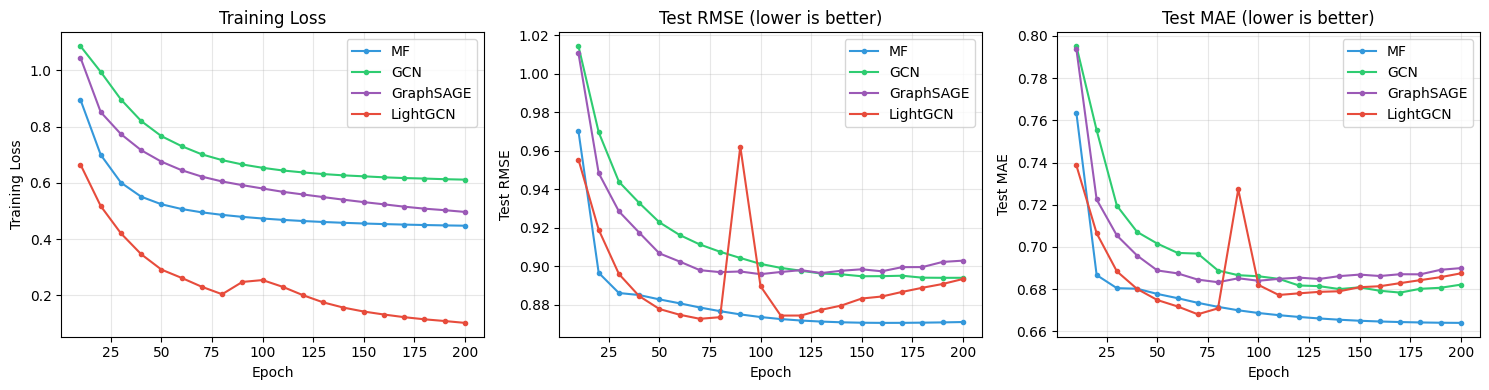

In [75]:
# Plot training curves
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

colors = {'MF': '#3498db', 'GCN': '#2ecc71', 'GraphSAGE': '#9b59b6', 'LightGCN': '#e74c3c'}

# Loss
ax = axes[0]
for name, history in results.items():
    epochs_x = range(10, EPOCHS + 1, 10)
    ax.plot(epochs_x, history['train_loss'], marker='o', label=name, 
            markersize=3, color=colors[name])
ax.set_xlabel('Epoch')
ax.set_ylabel('Training Loss')
ax.set_title('Training Loss')
ax.legend()
ax.grid(True, alpha=0.3)

# RMSE
ax = axes[1]
for name, history in results.items():
    epochs_x = range(10, EPOCHS + 1, 10)
    ax.plot(epochs_x, history['test_rmse'], marker='o', label=name,
            markersize=3, color=colors[name])
ax.set_xlabel('Epoch')
ax.set_ylabel('Test RMSE')
ax.set_title('Test RMSE (lower is better)')
ax.legend()
ax.grid(True, alpha=0.3)

# MAE
ax = axes[2]
for name, history in results.items():
    epochs_x = range(10, EPOCHS + 1, 10)
    ax.plot(epochs_x, history['test_mae'], marker='o', label=name,
            markersize=3, color=colors[name])
ax.set_xlabel('Epoch')
ax.set_ylabel('Test MAE')
ax.set_title('Test MAE (lower is better)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [76]:
# Final comparison table
print("\n" + "=" * 70)
print("FINAL RESULTS")
print("=" * 70)

print(f"\n{'Model':<12} {'Final RMSE':<12} {'Final MAE':<12} {'Best RMSE':<12} {'Best MAE':<12}")
print("-" * 60)

for name, history in results.items():
    final_rmse = history['test_rmse'][-1]
    final_mae = history['test_mae'][-1]
    best_rmse = min(history['test_rmse'])
    best_mae = min(history['test_mae'])
    print(f"{name:<12} {final_rmse:<12.4f} {final_mae:<12.4f} {best_rmse:<12.4f} {best_mae:<12.4f}")

# Find winner
best_model = min(results.keys(), key=lambda x: min(results[x]['test_rmse']))
print(f"\n🏆 Best Model: {best_model}")


FINAL RESULTS

Model        Final RMSE   Final MAE    Best RMSE    Best MAE    
------------------------------------------------------------
MF           0.8710       0.6640       0.8705       0.6640      
GCN          0.8940       0.6822       0.8940       0.6784      
GraphSAGE    0.9029       0.6900       0.8959       0.6833      
LightGCN     0.8933       0.6875       0.8727       0.6681      

🏆 Best Model: MF


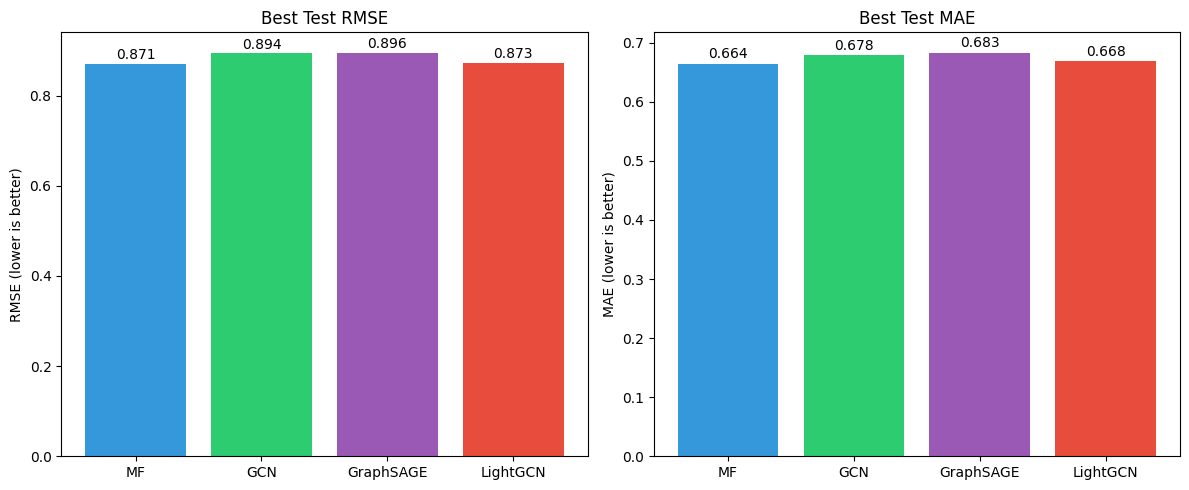

In [77]:
# Bar chart
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

models = list(results.keys())
final_rmse = [min(results[m]['test_rmse']) for m in models]  # Best RMSE
final_mae = [min(results[m]['test_mae']) for m in models]    # Best MAE

color_list = [colors[m] for m in models]

ax = axes[0]
bars = ax.bar(models, final_rmse, color=color_list)
ax.set_ylabel('RMSE (lower is better)')
ax.set_title('Best Test RMSE')
for bar, val in zip(bars, final_rmse):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f'{val:.3f}', ha='center', fontsize=10)

ax = axes[1]
bars = ax.bar(models, final_mae, color=color_list)
ax.set_ylabel('MAE (lower is better)')
ax.set_title('Best Test MAE')
for bar, val in zip(bars, final_mae):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f'{val:.3f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

---
## Part 8: Show Actual vs Predicted (Like Your TF Code Output)

In [78]:
def show_predictions(model, edge_index, test_users, test_movies, test_ratings,
                     df_movies, unique_movies, model_name, n_samples=15):
    """
    Show actual vs predicted ratings.
    Like your TF code output:
    'Movie: XXX, Your rating is X, Predicted rating is X.XX'
    """
    model.eval()
    
    with torch.no_grad():
        pred = model(edge_index, test_users[:n_samples], test_movies[:n_samples])
        pred = pred.clamp(0.5, 5.0)
    
    actual = test_ratings[:n_samples]
    
    print(f"\n{model_name} - Actual vs Predicted Ratings")
    print("=" * 70)
    
    total_error = 0
    for i in range(n_samples):
        movie_idx = test_movies[i].item()
        movie_id = unique_movies[movie_idx]
        movie_title = df_movies[df_movies['movieId'] == movie_id]['title'].values[0][:35]
        
        act = actual[i].item()
        prd = pred[i].item()
        err = abs(act - prd)
        total_error += err
        
        print(f"{movie_title:<35} | Actual: {act:.1f} | Predicted: {prd:.2f} | Error: {err:.2f}")
    
    print("-" * 70)
    print(f"Average Error: {total_error / n_samples:.3f}")
    
    return pred, actual

In [79]:
# Show predictions for all models
print("\n" + "#" * 70)
print("PREDICTION COMPARISON")
print("#" * 70)

models_dict = {
    'MF': mf_model,
    'GCN': gcn_model,
    'GraphSAGE': sage_model,
    'LightGCN': lightgcn_model
}

for name, model in models_dict.items():
    show_predictions(
        model, edge_index,
        test_users_t, test_movies_t, test_ratings_t,
        df_movies, unique_movies, name
    )


######################################################################
PREDICTION COMPARISON
######################################################################

MF - Actual vs Predicted Ratings
Robin Hood (2010)                   | Actual: 4.5 | Predicted: 2.92 | Error: 1.58
In the Line of Fire (1993)          | Actual: 3.0 | Predicted: 3.33 | Error: 0.33
Point Break (1991)                  | Actual: 3.0 | Predicted: 2.76 | Error: 0.24
Who Framed Roger Rabbit? (1988)     | Actual: 4.0 | Predicted: 4.10 | Error: 0.10
Hunt for Red October, The (1990)    | Actual: 4.0 | Predicted: 3.57 | Error: 0.43
Lord of Illusions (1995)            | Actual: 4.0 | Predicted: 2.92 | Error: 1.08
300 (2007)                          | Actual: 3.5 | Predicted: 3.73 | Error: 0.23
Dr. Strangelove or: How I Learned t | Actual: 4.5 | Predicted: 3.35 | Error: 1.15
Charlie's Angels: Full Throttle (20 | Actual: 0.5 | Predicted: 2.57 | Error: 2.07
Anchorman: The Legend of Ron Burgun | Actual: 3.5 | Predicted: 

In [80]:
# Show predictions for best model
# Find best model
min(results.keys(), key=lambda x: results[x]['test_mae'][-1])


'MF'

In [81]:
# Updated diagnosis to show scale parameter too
print("=" * 60)
print("DIAGNOSIS: Are embeddings contributing?")
print("=" * 60)

for name, model in models_dict.items():
    model.eval()
    with torch.no_grad():
        user_idx = test_users_t[:100]
        movie_idx = test_movies_t[:100]

        if hasattr(model, 'embedding'):
            x = model.embedding.weight
            x = model.conv1(x, edge_index)
            x = F.relu(x)
            x = model.conv2(x, edge_index)
            x = F.normalize(x, p=2, dim=1)
            user_emb = x[:num_users][user_idx]
            movie_emb = x[num_users:][movie_idx]
        elif hasattr(model, 'convs'):
            x = torch.cat([model.user_embedding.weight,
                           model.movie_embedding.weight], dim=0)
            all_emb = [x]
            for conv in model.convs:
                x = conv(x, edge_index)
                all_emb.append(x)
            x = torch.stack(all_emb, dim=0).mean(dim=0)
            x = F.normalize(x, p=2, dim=1)
            user_emb = x[:num_users][user_idx]
            movie_emb = x[num_users:][movie_idx]
        else:
            user_emb = model.user_embedding(user_idx)
            movie_emb = model.movie_embedding(movie_idx)

        dot_product = (user_emb * movie_emb).sum(dim=1)

        # Get scale if exists
        scale = model.scale.item() if hasattr(model, 'scale') else 1.0
        scaled_dot = dot_product * scale

        user_bias = model.user_bias(user_idx).squeeze()
        movie_bias = model.movie_bias(movie_idx).squeeze()
        global_mean = model.global_mean

        total_pred = scaled_dot + user_bias + movie_bias + global_mean

        print(f"\n{name}:")
        print(f"  Dot product (raw):    mean={dot_product.mean():.4f}, std={dot_product.std():.4f}")
        print(f"  Scale parameter:      {scale:.4f}")
        print(f"  Dot product (scaled): mean={scaled_dot.mean():.4f}, std={scaled_dot.std():.4f}")
        print(f"  User bias:            mean={user_bias.mean():.4f}, std={user_bias.std():.4f}")
        print(f"  Movie bias:           mean={movie_bias.mean():.4f}, std={movie_bias.std():.4f}")
        print(f"  Global mean:          {global_mean.item():.4f}")
        print(f"  Total prediction:     mean={total_pred.mean():.4f}, std={total_pred.std():.4f}")

DIAGNOSIS: Are embeddings contributing?

MF:
  Dot product (raw):    mean=0.0242, std=0.1561
  Scale parameter:      1.0000
  Dot product (scaled): mean=0.0242, std=0.1561
  User bias:            mean=-0.0866, std=0.3829
  Movie bias:           mean=0.0348, std=0.4674
  Global mean:          3.5016
  Total prediction:     mean=3.4740, std=0.6201

GCN:
  Dot product (raw):    mean=0.3300, std=0.1787
  Scale parameter:      0.9181
  Dot product (scaled): mean=0.3030, std=0.1641
  User bias:            mean=-0.1541, std=0.3943
  Movie bias:           mean=-0.0449, std=0.4194
  Global mean:          3.5016
  Total prediction:     mean=3.6055, std=0.6146

GraphSAGE:
  Dot product (raw):    mean=0.8421, std=0.0813
  Scale parameter:      1.1494
  Dot product (scaled): mean=0.9679, std=0.0934
  User bias:            mean=-0.2670, std=0.3298
  Movie bias:           mean=-0.1351, std=0.4388
  Global mean:          3.5016
  Total prediction:     mean=4.0674, std=0.5673

LightGCN:
  Dot product (

If the dot product is 0 it means the regularization is too high!

---
## Part 9: Movie Similarity Test

In [60]:
def find_similar_movies(model, edge_index, num_users, num_movies,
                        movie_to_idx, unique_movies, df_movies, 
                        test_movie_name, top_k=10):
    """
    Find movies similar to a given movie.
    """
    model.eval()
    
    with torch.no_grad():
        # Get movie embeddings
        if hasattr(model, 'embedding'):
            # GCN/GraphSAGE
            x = model.embedding.weight
            x = model.conv1(x, edge_index)
            x = F.relu(x)
            x = model.conv2(x, edge_index)
            movie_emb = x[num_users:].numpy()
        elif hasattr(model, 'convs'):
            # LightGCN
            x = torch.cat([model.user_embedding.weight, 
                          model.movie_embedding.weight], dim=0)
            all_emb = [x]
            for conv in model.convs:
                x = conv(x, edge_index)
                all_emb.append(x)
            x = torch.stack(all_emb, dim=0).mean(dim=0)
            movie_emb = x[num_users:].numpy()
        else:
            # MF
            movie_emb = model.movie_embedding.weight.numpy()
    
    # Find test movie
    match = df_movies[df_movies['title'].str.contains(test_movie_name, case=False, na=False)]
    if len(match) == 0:
        print(f"Movie '{test_movie_name}' not found!")
        return
    
    test_movie_id = match['movieId'].values[0]
    test_movie_title = match['title'].values[0]
    
    if test_movie_id not in movie_to_idx:
        print(f"Movie '{test_movie_name}' not in training data!")
        return
    
    test_idx = movie_to_idx[test_movie_id]
    test_emb = movie_emb[test_idx]
    
    # Calculate similarities
    similarities = movie_emb @ test_emb
    top_indices = np.argsort(similarities)[::-1][1:top_k+1]
    
    print(f"\nMovies similar to: '{test_movie_title}'")
    print("=" * 60)
    
    for i, idx in enumerate(top_indices, 1):
        movie_id = unique_movies[idx]
        title = df_movies[df_movies['movieId'] == movie_id]['title'].values[0]
        sim = similarities[idx]
        print(f"{i:2d}. {title[:45]:<45} (sim: {sim:.3f})")

In [61]:
# Test movie similarity
print("\n" + "#" * 70)
print("MOVIE SIMILARITY TEST")
print("#" * 70)

test_movies_list = ["Toy Story", "Matrix", "Titanic"]

for test_movie in test_movies_list:
    print(f"\n--- Using GCN model ---")
    find_similar_movies(
        gcn_model, edge_index, num_users, num_movies,
        movie_to_idx, unique_movies, df_movies,
        test_movie, top_k=5
    )


######################################################################
MOVIE SIMILARITY TEST
######################################################################

--- Using GCN model ---

Movies similar to: 'Toy Story (1995)'
 1. Jeff Ross Roasts the Border (2017)            (sim: 6.147)
 2. The Big Bus (1976)                            (sim: 5.619)
 3. Burnt by the Sun (Utomlyonnye solntsem) (1994 (sim: 5.597)
 4. Seve (2014)                                   (sim: 5.375)
 5. Goal! The Dream Begins (Goal!) (2005)         (sim: 4.929)

--- Using GCN model ---

Movies similar to: 'Matrix, The (1999)'
 1. Jeff Ross Roasts the Border (2017)            (sim: 6.422)
 2. The Big Bus (1976)                            (sim: 5.894)
 3. Burnt by the Sun (Utomlyonnye solntsem) (1994 (sim: 5.857)
 4. Seve (2014)                                   (sim: 5.641)
 5. Goal! The Dream Begins (Goal!) (2005)         (sim: 5.159)

--- Using GCN model ---

Movies similar to: 'Titanic (1997)'
 1. Jeff Ross

---
## Part 10: User-Movie Alignment Test

In [62]:
def test_user_alignment(model, edge_index, num_users, num_movies,
                        df_ratings, df_movies, movie_to_idx, unique_movies,
                        test_user_id=1):
    """
    Test if user embeddings are close to movies they rated highly.
    """
    model.eval()
    
    with torch.no_grad():
        # Get embeddings
        if hasattr(model, 'embedding'):
            x = model.embedding.weight
            x = model.conv1(x, edge_index)
            x = F.relu(x)
            x = model.conv2(x, edge_index)
            user_emb = x[:num_users].numpy()
            movie_emb = x[num_users:].numpy()
        elif hasattr(model, 'convs'):
            x = torch.cat([model.user_embedding.weight, 
                          model.movie_embedding.weight], dim=0)
            all_emb = [x]
            for conv in model.convs:
                x = conv(x, edge_index)
                all_emb.append(x)
            x = torch.stack(all_emb, dim=0).mean(dim=0)
            user_emb = x[:num_users].numpy()
            movie_emb = x[num_users:].numpy()
        else:
            user_emb = model.user_embedding.weight.numpy()
            movie_emb = model.movie_embedding.weight.numpy()
    
    user_idx = test_user_id - 1  # Convert to 0-indexed
    user_vec = user_emb[user_idx]
    
    # Get user's ratings
    user_ratings = df_ratings[df_ratings['userId'] == test_user_id].sort_values('rating', ascending=False)
    
    print(f"\nUser {test_user_id}'s HIGH rated movies (rating >= 4.5):")
    print("-" * 60)
    high_rated = user_ratings[user_ratings['rating'] >= 4.5].head(5)
    for _, row in high_rated.iterrows():
        movie_id = row['movieId']
        if movie_id in movie_to_idx:
            movie_idx = movie_to_idx[movie_id]
            movie_vec = movie_emb[movie_idx]
            sim = np.dot(user_vec, movie_vec)
            title = df_movies[df_movies['movieId'] == movie_id]['title'].values[0][:35]
            print(f"  {title:<35} rating={row['rating']:.1f}, similarity={sim:.3f}")
    
    print(f"\nUser {test_user_id}'s LOW rated movies (rating <= 2.5):")
    print("-" * 60)
    low_rated = user_ratings[user_ratings['rating'] <= 2.5].head(5)
    if len(low_rated) > 0:
        for _, row in low_rated.iterrows():
            movie_id = row['movieId']
            if movie_id in movie_to_idx:
                movie_idx = movie_to_idx[movie_id]
                movie_vec = movie_emb[movie_idx]
                sim = np.dot(user_vec, movie_vec)
                title = df_movies[df_movies['movieId'] == movie_id]['title'].values[0][:35]
                print(f"  {title:<35} rating={row['rating']:.1f}, similarity={sim:.3f}")
    else:
        print("  (No low ratings)")

In [63]:
# Test user alignment for each model
print("\n" + "#" * 70)
print("USER-MOVIE ALIGNMENT TEST")
print("#" * 70)


for name, model in models_dict.items():
    print(f"\n{'='*60}")
    print(f"Model: {name}")
    print(f"{'='*60}")
    test_user_alignment(
        model, edge_index, num_users, num_movies,
        df_ratings, df_movies, movie_to_idx, unique_movies,
        test_user_id=1
    )


######################################################################
USER-MOVIE ALIGNMENT TEST
######################################################################

Model: MF

User 1's HIGH rated movies (rating >= 4.5):
------------------------------------------------------------
  M*A*S*H (a.k.a. MASH) (1970)        rating=5.0, similarity=0.392
  Excalibur (1981)                    rating=5.0, similarity=0.285
  Indiana Jones and the Last Crusade  rating=5.0, similarity=-0.088
  Pink Floyd: The Wall (1982)         rating=5.0, similarity=0.201
  From Russia with Love (1963)        rating=5.0, similarity=0.177

User 1's LOW rated movies (rating <= 2.5):
------------------------------------------------------------
  Psycho (1960)                       rating=2.0, similarity=-0.794
  Mummy, The (1999)                   rating=2.0, similarity=-0.907
  Toys (1992)                         rating=2.0, similarity=-0.350
  I Still Know What You Did Last Summ rating=2.0, similarity=-0.251
 

---
## Summary

### What We Fixed (Now Matches Your TensorFlow Code)

| Component | Your TF Code | Our PyTorch Code |
|-----------|--------------|------------------|
| **Prediction** | `X @ W.T + b + Ymean` | `dot + user_b + movie_b + global_mean` |
| **Loss** | `0.5 * sum((pred-Y)² * R)` | `MSE(pred, ratings)` (only observed) |
| **Regularization** | `λ * (‖X‖² + ‖W‖²)` | `get_regularization_loss(λ)` |
| **Global Mean** | `pm = p + Ymean` | `self.global_mean` in model |

### Model Comparison

Run the notebook to see which model performs best with these improvements!